In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

---
# Part 3. Extract feature from texts and images

## Images

In [3]:
# load the dataset from sklearn
from sklearn.datasets import load_digits
digits = load_digits()

print(digits['images'].shape)
print(digits['data'].shape)
print(digits['target'].shape)

(1797, 8, 8)
(1797, 64)
(1797,)


In [4]:
# images contain 8x8 black'n'white pictures of hadwritten digits
digits['images'][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

#### 1. Explore the data

Let's plot several pictures, split dataset on train and test

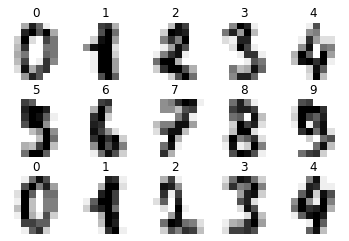

In [6]:
# make a plot
_, axes = plt.subplots(3, 5)
axes = axes.flatten()

for ax, image, label in zip(axes, digits['images'], digits['target']):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(label)

We will assume that each pixel is a feature. Note, that images were already rechaped into vectors for us in `digits['data']` 

In [8]:
from sklearn.model_selection import train_test_split

# perform train test split
X_train, X_test, y_train, y_test = \
    train_test_split(digits['data'], digits['target'])

#### 2. Train the model

We can now train the model. This is a classification task with 10 classes. 

The model, that we will use is called `KNeighborsClassifier` (kNN). It does not have trainable parameters and works in the following manner:
* Remember the training data
* When new point arrives 
    * find `K` nearest points in the training dataset (e.g. by euclidean distance)
    * return the most freaquent class among these `K`.
    

   Create and train the following pipeline:
* Scale the input vectorized image 
* Classify by kNN

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# define pipeline
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('clf', KNeighborsClassifier())
])
# fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

#### 3. Evaluate on test dataset

We will use accuracy - proportion of correct predictions, to measure the quality

In [10]:
from sklearn.metrics import accuracy_score

# predict on test set
y_pred = pipe.predict(X_test)
# compute accuracy
score = accuracy_score(y_pred, y_test)

In [13]:
print(score)

0.9777777777777777


**Optional task**

Implement accuracy youself usinf numpy only;


In [17]:
def my_accuracy(true, predicted):
    # your code here
    return np.where(predicted == true)[0].shape[0] / len(predicted)
    
# test that your function work the same as `accuracy_score` from sklearn
my_accuracy(y_pred, y_test)

0.9777777777777777

---
## Texts

### 1.1 Convert documents to vectors

Note that out dataset now is a set of documents (or texts): $D = (d_1, \dots, d_N)$

We will assume that there is vocabulary of size $M$, which contains all possible words, from which our documents are composed. 

Of course, each documents has different number of words in it. 

Today, we will consider 2 options how to represent texts with the vectors (embeddings):
1. Bag of words
2. Tf-idf

Let us firstly use the simplest example to undertand how both methods work:

In [18]:
d1 = "This is my favourite movie"
d2 = "Is this movie boring? Yes, it is!"
d3 = "This is an exiting movie"

In [19]:
import re
D = [re.sub('[.!?,]', '', d.lower()).split(' ') for d in [d1, d2, d3]]
D

[['this', 'is', 'my', 'favourite', 'movie'],
 ['is', 'this', 'movie', 'boring', 'yes', 'it', 'is'],
 ['this', 'is', 'an', 'exiting', 'movie']]

The Vocabulary for such dataset would be:

In [21]:
all_words = sum(D, [])
V = list(set(all_words))
print(V)

['movie', 'my', 'exiting', 'favourite', 'this', 'boring', 'yes', 'an', 'it', 'is']


#### Option 1. Bag of words

We can say, that text is charaterized by the vector of length $M$, which shows how many times each word from the vector is present in the document

Let us now calculate bag of words for each document

In [24]:
X = np.zeros((len(D), len(V)))

for j, v in enumerate(V):
    for i, d in enumerate(D):
        X[i, j] = sum([1 for w in d if w == v])

In [25]:
X

array([[1., 1., 0., 1., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 1., 1., 0., 1., 2.],
       [1., 0., 1., 0., 1., 0., 0., 1., 0., 1.]])

#### Option 2. Tf-idf

**Term Frequency times Inverce Document Frequency**

A method to describe each document in the dataset with a vector of the same length. Takes into account, how often the word appears in the whole dataset.



**Term frequency (tf)** - number of times a term occurs in a given document
$$
tf(t, d) = \frac{\# t \text{ in } d}{len(d)}
$$


**Inverce document frequency (idf)** - measures informativeness of a term

$$
idf(t) = \log \frac{N}{(\# d \text{ with } t)} , N - \text{ number of documents}
$$

If the word occures almost in all the documents (e.g. article, popular verb), then $idf$ will be very low.

---
Now we can covert each document onti the vector of size $M$:
$$
d \rightarrow \left(tf(t_1, d)\cdot idf(t_1),\,\, \dots, \,\, tf(t_M, d) \cdot idf(t_M)\right)
$$


---
Let us calculate it for our simple example

In [26]:
print(D, '\n')
print(V)

[['this', 'is', 'my', 'favourite', 'movie'], ['is', 'this', 'movie', 'boring', 'yes', 'it', 'is'], ['this', 'is', 'an', 'exiting', 'movie']] 

['movie', 'my', 'exiting', 'favourite', 'this', 'boring', 'yes', 'an', 'it', 'is']


In [27]:
# tf
tf = np.zeros((len(D), len(V)))

for j, v in enumerate(V):
    for i, d in enumerate(D):
        tf[i, j] = sum([1 for w in d if w == v]) / len(d)

In [28]:
#idf
idf = np.zeros(len(V))

for j, v in enumerate(V):
    idf[j] = np.log(len(D) / sum([1 for d in D if v in d]))

In [29]:
X = tf*idf
np.round(X, 2)

array([[0.  , 0.22, 0.  , 0.22, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.16, 0.  , 0.16, 0.  ],
       [0.  , 0.  , 0.22, 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.  ]])

---
**Optional task**

Below we will use `BoW` and `tf-idf` features to classify texts from the dataset with news articles. 

### BoW and Tf-Idf in Sklearn

In practice, we can use `Trasfromers` from sklearn to get the same vector representation of texts as we implemented above. 

#### 1. Import the data

In [8]:
import pandas as pd

categories = ['alt.atheism', 'sci.space']
train = pd.read_csv('train_news.csv', index_col=0)
X_train, y_train = train.news, train.target


test = pd.read_csv('test_news.csv', index_col=0)
X_test, y_test = test.news, test.target

#### 2. Explore the data



In [9]:
for i in range(3):
    print('label:',y_train[i])
    print(X_train[i])
    print('-------\n')

label: 0
: 
: >> Please enlighten me.  How is omnipotence contradictory?
: 
: >By definition, all that can occur in the universe is governed by the rules
: >of nature. Thus god cannot break them. Anything that god does must be allowed
: >in the rules somewhere. Therefore, omnipotence CANNOT exist! It contradicts
: >the rules of nature.
: 
: Obviously, an omnipotent god can change the rules.

When you say, "By definition", what exactly is being defined;
certainly not omnipotence. You seem to be saying that the "rules of
nature" are pre-existant somehow, that they not only define nature but
actually cause it. If that's what you mean I'd like to hear your
further thoughts on the question.
-------

label: 1
In <19APR199320262420@kelvin.jpl.nasa.gov> baalke@kelvin.jpl.nasa.gov 

Sorry I think I missed a bit of info on this Transition Experiment. What is it?

Will this mean a loss of data or will the Magellan transmit data later on ??

BTW: When will NASA cut off the connection with Magellan

#### 3.1 BoW 

Our pipeline:
* BoW vectorizer
* kNN classifier

We will use accuracy to evaluate model on test

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [4]:
# Define traning pipeline
bow = CountVectorizer(min_df=0.1, stop_words='english')

pipe = # your code here

# Fit on train data
pipe.fit(X_train, y_train)

# Evaluate on test data (compute accuracy)
# your code here

#### 3.2 Tf-Idf

Let's repeat the same procedure, but for tf-idf vectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define traning pipeline
tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=0.1, stop_words='english')

pipe = # your code here


# Fit
# your code here

# Evaluate on test
# your code here